In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import numpy as np

import os
import glob

In [2]:
# Set up cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [64]:
# Fucntion for visualizing file structure
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        if len(files) > 0:
            print('{}({} files)'.format(subindent, len(files)))

In [67]:
# Select whether you are running on Google Collab ('collab') or locally ('local')
system = 'local'
s = os.sep

if system == 'collab':
    # Mount google drive
    from google.colab import drive
    drive.mount(f'{s}content{s}drive')

    root_path = f'{s}content{s}drive{s}My Drive{s}Collab Data{s}Chest X-Ray{s}chest_xray'
    
elif system == 'local':
    root_path = f'../{s}data{s}chest_xray'
else:
    root_path = 'NULL'
    
    
if os.path.isdir(root_path):
    print('Data Directory Structure:\n')
    list_files(root_path)
else:
    print('Data folder doesnt exist')

Data Directory Structure:

chest_xray/
    test/
        NORMAL/
            (234 files)
        PNEUMONIA/
            (390 files)
    train/
        NORMAL/
            (1341 files)
        PNEUMONIA/
            (3875 files)
    val/
        NORMAL/
            (8 files)
        PNEUMONIA/
            (8 files)


In [68]:
class XrayDataset(Dataset):
  '''
  Args:
    root_dir : path to the directory which contains the NORMAL/PNEMONIA split
    transform : transforms to be applied to each image
  '''
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.samples = []
    self.transform = transform

    for label in os.listdir(root_dir):
      label_folder = os.path.join(root_dir, label)
      
      for image_path in os.listdir(label_folder):
        self.samples.append((os.path.join(label_folder, image_path), label))

  def __len__(self):
        return len(self.samples)

  def __getitem__(self, idx):
    
    if torch.is_tensor(idx):
      idx = idx.tolist()

    im_path, label = self.samples[idx]

    im = Image.open(im_path)
    
    if im.mode == 'L':
      im = im.convert('RGB')
    
    if self.transform:
      im = self.transform(im)
      
    classes = {'PNEUMONIA': 1.0, 'NORMAL': 0.0}
    return {'image': im, 'class': classes[label], 'path': im_path}


In [69]:
bs = 64

transform = transforms.Compose([transforms.RandomResizedCrop((255,255)),
                                transforms.ToTensor()])
test = XrayDataset(os.path.join(root_path, 'train'), transform=transform)
dl = DataLoader(test, 
                batch_size=bs,
                shuffle=True)

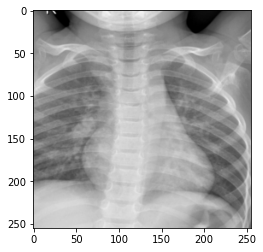

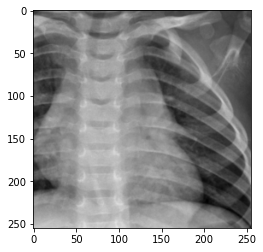

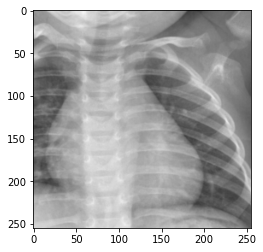

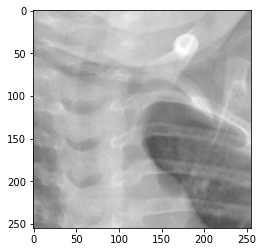

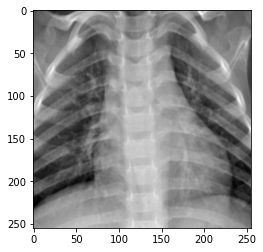

In [70]:
# Show some of the images
b=0
for i in iter(test):
  b += 1
  plt.imshow(i['image'].permute(1, 2, 0))
  plt.show()
  if b == 5:
    break

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(60 * 60 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 60 * 60 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [72]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [74]:
def acc(outputs, labels, threshold, decimals):
    rounded_outputs = torch.where(outputs > threshold, 
                                    torch.ones(outputs.size()).to(device), 
                                    torch.zeros(outputs.size()).to(device))
    acc = torch.eq(rounded_outputs, labels.float()).float().sum().item()
    return round(acc / outputs.size()[0], decimals)

In [38]:
# Training loop

losses = []
accuracy = []
running_loss = 0
running_acc = 0
epochs = 5

for j in range(epochs):
    for i, data_dic in enumerate(dl):
      optimizer.zero_grad()

      data, labels = data_dic['image'].to(device), data_dic['class'].to(device)
      outputs = net(data).view(-1)

      loss = criterion(outputs, labels.float())
      loss.backward()
      optimizer.step()
      
      calced_acc = acc(outputs,labels,0.75,3)
      running_loss += loss.item()
      running_acc += calced_acc
        
      losses.append(loss.item())
      accuracy.append(calced_acc)      
    
      if i % 5 == 4:
          print('[%d,%5d] loss: %.3f acc: %.3f' %(j + 1, i + 1, running_loss/5, running_acc/5))
          running_loss = 0
          running_acc = 0

[1,    5] loss: 0.184 acc: 0.559
[1,   10] loss: 0.182 acc: 0.591
[1,   15] loss: 0.173 acc: 0.541
[1,   20] loss: 0.157 acc: 0.738
[1,   25] loss: 0.167 acc: 0.550
[1,   30] loss: 0.157 acc: 0.672
[1,   35] loss: 0.152 acc: 0.687
[1,   40] loss: 0.137 acc: 0.731
[1,   45] loss: 0.144 acc: 0.641
[1,   50] loss: 0.139 acc: 0.725
[1,   55] loss: 0.180 acc: 0.566
[1,   60] loss: 0.174 acc: 0.600
[1,   65] loss: 0.165 acc: 0.685
[1,   70] loss: 0.133 acc: 0.622
[1,   75] loss: 0.159 acc: 0.712
[1,   80] loss: 0.165 acc: 0.597
[2,    5] loss: 0.235 acc: 0.888
[2,   10] loss: 0.173 acc: 0.588
[2,   15] loss: 0.168 acc: 0.688
[2,   20] loss: 0.149 acc: 0.697
[2,   25] loss: 0.157 acc: 0.656
[2,   30] loss: 0.172 acc: 0.669
[2,   35] loss: 0.163 acc: 0.575
[2,   40] loss: 0.168 acc: 0.650
[2,   45] loss: 0.179 acc: 0.609
[2,   50] loss: 0.147 acc: 0.631
[2,   55] loss: 0.159 acc: 0.719
[2,   60] loss: 0.164 acc: 0.544
[2,   65] loss: 0.160 acc: 0.709
[2,   70] loss: 0.139 acc: 0.653
[2,   75] 

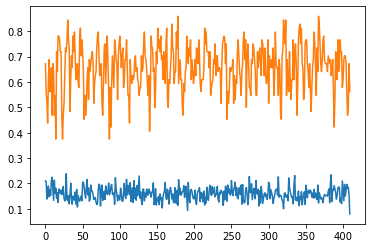

In [39]:
# We can graph accuracy and loss here
plt.plot(losses)
plt.plot(accuracy)
plt.show()